# Trajectory inference for hematopoiesis in mouse

Reconstructing myeloid and erythroid differentiation for data of [Paul et al. (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

In [2]:
#sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
#results_file = './write/paul15.h5ad'
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')  
sc.settings.figdir='/home/anne/Documents/featurecloud/pca/horizontal-pca/figures/single-cell'# low dpi (dots per inch) yields small inline figures

In [3]:
adata = sc.datasets.paul15()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, copying.


Let us work with a higher precision than the default 'float32' to ensure _exactly_ the same results across different computational platforms.

In [4]:
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it

## Preprocessing and Visualization

Apply a simple [preprocessing recipe](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.recipe_zheng17.html).

In [5]:
sc.pp.recipe_zheng17(adata)

In [6]:
sc.tl.pca(adata, svd_solver='arpack')

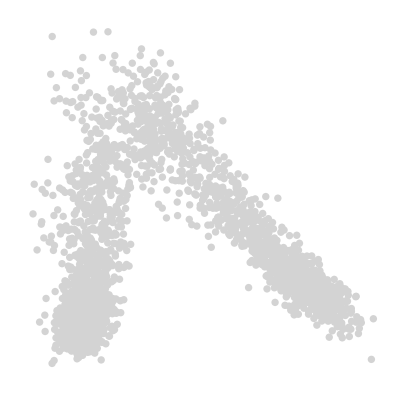

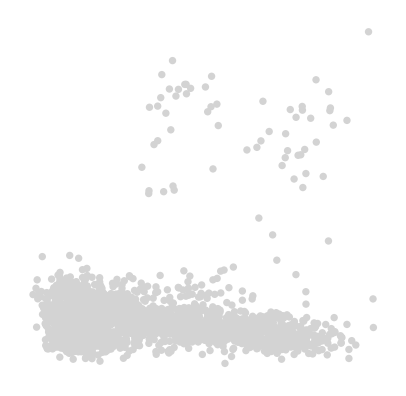

In [7]:
sc.pl.pca(adata, components =['1,2'], save='paga_12_centralised')
sc.pl.pca(adata, components =['2,3'], save='paga_23_centralised')

In [8]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

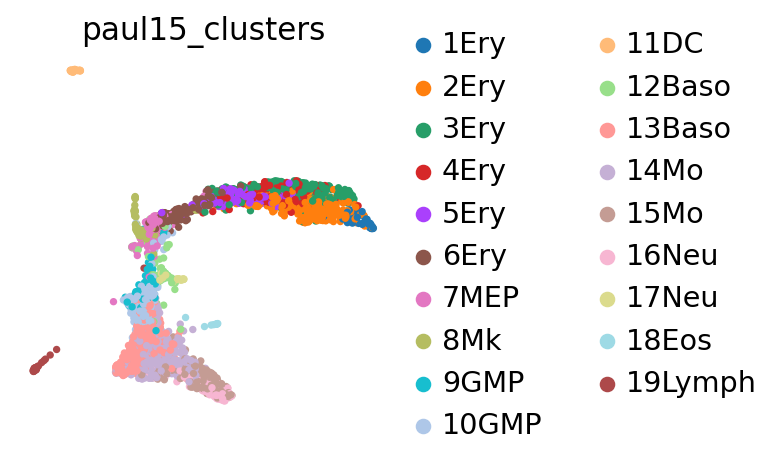

In [9]:
sc.pl.draw_graph(adata, color='paul15_clusters', save='graph_orig')

## Optional: Denoising the graph

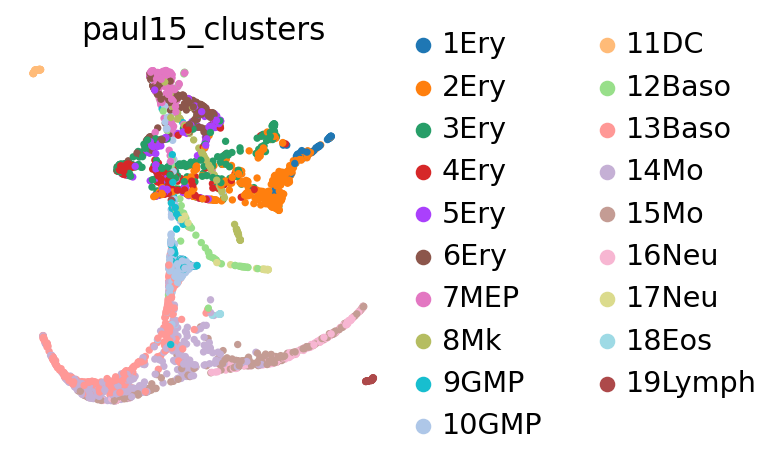

In [10]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')
sc.tl.draw_graph(adata)
sc.pl.draw_graph(adata, color='paul15_clusters',save='graph_orig_denoised')

This still looks messy, but in a different way: a lot of the branches are overplotted.

## Clustering and PAGA

<div class="alert alert-info">

**Note**

Note that today, we'd use `sc.tl.leiden` - here, we use `sc.tl.louvain` the sake of reproducing the paper results.
    
</div>  

In [11]:
sc.tl.leiden(adata, resolution=1.0)

Annotate the clusters using marker genes.

| cell type | marker |
| --- | --- |
|HSCs | Procr |
|Erythroids | Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1 |
|Neutrophils | Elane, Cebpe, Ctsg, Mpo, Gfi1 |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Mcpt8, Prss34 |
|B cells | Cd19, Vpreb2, Cd79a |
|Mast cells| Cma1, Gzmb, CD117/C-Kit |
|Mast cells & Basophils| Ms4a2, Fcer1a, Cpa3, CD203c (human)|

For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away.

In [12]:
sc.tl.paga(adata, groups='leiden')

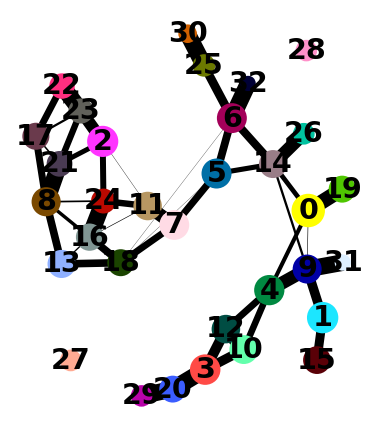

In [13]:
sc.pl.paga(adata, color=['leiden'], save='leiden_orig')

Actually annotate the clusters --- note that *Cma1* is a Mast cell marker and only appears in a small fraction of the cells in the progenitor/stem cell cluster 8, see the single-cell resolved plot below.